In [1]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline,interp1d
import sys
sys.path.append('../expt_qslam/')
sys.path.append('../qslam/')

from visualiserisk import DataCube
from visualiserisk import *
from qslamdesignparams import GRIDDICT
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


# Define Error Analysis Regime

Pick loss metric type as (SSIM or RMS) to numerically extract low-loss lambda values:

In [2]:
metrictype_ = 3 # SSIM
metrictypename = 'SSIM'
OPT_LAMBDA=True
NUM_TRIALS = 500 # 50, 150, 500

Pick fixed lambda (False) regime:

In [3]:
# Fixed Lambda
opt_lambda_at_iteration = 7

# Maps, Optimisatio Curves
pick_msmt_regimes = [7, 11]
pick_msmt_regimes_maps = [4, 11]


Pick fitting method (a) least squares exponential fit ('expfit') or univariate interpolation ('linfit', 'rbffit')

In [4]:
FIT_TYPE='linfit'

# Define Experiment Parameter Regimes

The set of parameters are given in the dictionary format, LOOPS_DICT, and used for analysis via ParamUpdater. They are fixed for the type of simulations investigated. 

In [5]:
msmt_per_qubit_scan = [1] 
meta_max_iter_scan = [ 1, 2, 3, 4, 6, 12, 18, 24, 30, 60, 72, 96, 120, 246]
lambda_databse = np.load('../expt_qslam/lambda_pairs_2.npz')
lambda1 = list(lambda_databse['lambda_1'][0:]) 
lambda2 = list(lambda_databse['lambda_2'][0:]) 

lambda_scan = zip(lambda1, lambda2)

LOOPS_DICT = {"meta_max_iter_scan":meta_max_iter_scan, 
              "lambda_scan":lambda_scan,
              "msmt_per_qubit_scan": msmt_per_qubit_scan}

ParamUpdater = DataCube(LOOPS_DICT)

max_msmt_var = len(meta_max_iter_scan)
max_lambda_var_= len(lambda_scan) #32, 68, 95 is good but not as good as in paper 1. 
data_key_list = range(1, 2, 1) # range(1, 5, 1) Only CE Ramsey data analysed

THRESHOLD = 0.01 # effects graphical shading of optimal lambda results
max_cases = len(data_key_list)


# Interpolation 
start_iter=0
end_iter=max_msmt_var

# Final plot range
maxssim = 0.6
min_sims = [0.05]*4

In [6]:
def get_loss_data(data_key, idx_msmt_var, max_lambda_var=50, metrictype=3):
    ''' Return qslam loss values, naive data loss values, and list of index for lambda values from low to highest loss.
    Type of loss value (SSIM, RMS) is determined by metrictype.
    
    Returns:
    --------
    
            qslamdata (`float` | array):
                Expected loss values for qslam algorithm according risk metrictype 
            
            index_array (`int` | int):
                List of int denoting index of lambda values sorted from lowest to highest loss
            
            naivedata (`float` | array):
                Expected loss values for naive algorithm according risk metrictype 
    
            metrictype: Index of loss metric used in Risk_Matrix_Generator
                `2`: Single map RMSE
                `3` : Expected SSIM metric
    '''  
    full_data_matrix_ = np.load('../expt_qslam/2019_Jun_qslam_exptdata_'+str(data_key)+'.npz')
    
    if metrictype ==3 :
        full_data_matrix = full_data_matrix_['meta_ssim_pairs'] 
    
    if metrictype ==2 :
        full_data_matrix = full_data_matrix_['meta_empr_pairs'] 
    
    qslamdata = full_data_matrix[0: max_lambda_var, 0 , idx_msmt_var] # qslam is the first index
    naivedata = full_data_matrix[0: max_lambda_var, 1 , idx_msmt_var]
    index_array = np.argsort(qslamdata)

    return qslamdata, index_array, naivedata


def extract_optimal_cases(data_key_list, max_cases, max_msmt_var, max_lambda_var=50, metrictype=3):
    '''
    Return optimal lambda and loss informatio for a set of chosen experiments.
    This function draws the following parameters from the global namespace: weightratioslist
        
    '''
    
    optimal_matrix = np.zeros((max_cases, max_msmt_var, 3))
    naive_matrix = np.zeros((max_cases, max_msmt_var, 2))
    optimal_cases = np.zeros((max_cases, max_msmt_var, max_lambda_var))
    
    for idx_msmt_var in range(max_msmt_var):
        
        for idx_truth in range(max_cases):
            
            data_key = data_key_list[idx_truth]
            
            a, index_array, naive = get_loss_data(data_key, idx_msmt_var,
                                                  max_lambda_var=max_lambda_var,
                                                  metrictype=metrictype)

            optimal_matrix[idx_truth, idx_msmt_var, 0] = a[index_array[0]]
            optimal_matrix[idx_truth, idx_msmt_var, 1] = lambda1[index_array[0]]
            optimal_matrix[idx_truth, idx_msmt_var, 2] = lambda2[index_array[0]]

            naive_matrix[idx_truth, idx_msmt_var, 0] = np.mean(naive)
            naive_matrix[idx_truth, idx_msmt_var, 1] = np.std(naive)
            
            truncate = len(index_array)           
            optimal_cases[idx_truth, idx_msmt_var, :truncate] = index_array
    
    return optimal_matrix, naive_matrix, optimal_cases


def norm_rmse_error_propagation(residualsdata):

    # independent error anlaysis across trials
    MSE = np.mean(residualsdata**2, axis=0)
    STD = np.std(residualsdata**2, axis=0)
    rel_error_MSE = MSE / STD
    RMSE = np.sqrt(MSE) 
    RSTD = RMSE * 0.5 * rel_error_MSE # error propagation from  X to Y when Y = X^n
    
    return RMSE, RSTD

# Analyze Lambda Values from Datasets

In [7]:
optimal_matrix, naive_matrix, optimal_cases = extract_optimal_cases(data_key_list, max_cases, max_msmt_var, 
                                                                    max_lambda_var=max_lambda_var_,
                                                                    metrictype=metrictype_)

print('Type of loss metric (name, flag):', metrictypename, metrictype_)
print "Optimal lambda values for each truth and max T:"
print optimal_cases[:, :, 0][0]
print('Fixed lambda choice:')
print optimal_cases[:, opt_lambda_at_iteration, 0]


('Type of loss metric (name, flag):', 'SSIM', 3)
Optimal lambda values for each truth and max T:
[134. 151. 172.  47. 107.  29. 249.  30.  30.  86.  30. 107.  30.  30.]
Fixed lambda choice:
[30.]


In [8]:
RUN_ANALYSIS_FOR_ERRORBARS=False
if RUN_ANALYSIS_FOR_ERRORBARS:
    
    for data_key in data_key_list:
        
        list_of_lambda_vals = list(optimal_cases[:, :, 0][0]) 
        list_of_lambda_vals+= list(optimal_cases[:,opt_lambda_at_iteration, 0])*max_msmt_var
        list_of_iteration_vals = range(len(msmts)) * 2
        np.savez('temp_selected_cases.npz', 
                 list_of_lambda_vals=list_of_lambda_vals, 
                 list_of_iteration_vals=list_of_iteration_vals)

        !which python
        !python Data_generator_from_expt_errorbars.py {data_key} 'temp_selected_cases.npz'
        

### Compute expected loss and standard deviations of datasets

In [9]:
test_dobjs = []
msmts = ParamUpdater.meta_max_iter_scan[:]

for idx_case in range(max_cases): # loop over true physical experiments 
            
    data_key = data_key_list[idx_case]
    try:
        dataobject = np.load('2020_Jan_exptdata_errbars_1_'+str(NUM_TRIALS)+'_trials.npz')
        test_dobjs.append(dataobject)
        print("Loaded", data_key)

    except:
        print("ERROR. Unique ID:", data_key)
        continue
            
trials=NUM_TRIALS
qslam_rms, naive_rms, qslam_ssim, naive_ssim = [], [], [], []

for idx_dobj in range(max_cases):
       
    expt_data = test_dobjs[idx_dobj]
    
    strt, end = 0, max_msmt_var
    if not OPT_LAMBDA:
        strt, end = max_msmt_var, max_msmt_var*2
    
    perqubit_qslamdata = expt_data['meta_empr_array'][strt: end, 0, :]
    qslam_rms.append(perqubit_qslamdata)

    perqubit_naivedata = expt_data['meta_empr_array'][strt: end , 1, :]
    naive_rms.append(perqubit_naivedata)

    qslam_ssim.append(expt_data['meta_ssim_array'][strt: end , 0, :])
    naive_ssim.append(expt_data['meta_ssim_array'][strt: end, 1, :])

    
for dataset in ['qslam_rms', 'naive_rms', 'qslam_ssim', 'naive_ssim']:
    vars()[dataset] = np.asarray(vars()[dataset]).reshape(len(test_dobjs), max_msmt_var, trials)
    
for dataset in ['qslam_rms', 'naive_rms', 'qslam_ssim', 'naive_ssim']:
    
    vars()[dataset+'_exp_loss'] = np.mean(vars()[dataset], axis=2)
    vars()[dataset+'_std_loss'] = np.std(vars()[dataset], axis=2)
    vars()[dataset+'_errbar_upp'] = vars()[dataset+'_exp_loss'] + vars()[dataset+'_std_loss']
    vars()[dataset+'_errbar_low'] = vars()[dataset+'_exp_loss'] - vars()[dataset+'_std_loss']


('Loaded', 1)


### Optimise fit to expected loss, upper and lower bounds of dataset

In [10]:
if FIT_TYPE != 'mixfit':
    x_space = np.linspace(0.0, 1.0, 601)  
if FIT_TYPE == 'mixfit':
    x_space = np.linspace(0.0, 0.5, 601)     

labels = ['mean', 'upper bound', 'lower bound']
data_labels = ['qslam_rms', 'naive_rms', 'qslam_ssim', 'naive_ssim']


## Least Squares Fit

In [11]:
def fit_expn(t, a, b, c):
    '''Exponential fitting function'''
    return a * np.exp(t*b) + c  # c excludes large error scores (few msmts) from the fit

def fit_sqrt(t, a, b, c):
    '''Assume fintie variance and uncorrelated random variables,  variance of average of t random variables
    is sigma ^2 / t. So expect reduction in variance proportional to 1 / sqrt(t).
    
    '''
    
    return (a /np.sqrt(t*b)) + c  # b excludes large error scores (few msmts) from the fit
    

In [12]:
if FIT_TYPE == 'mixfit':

    START_OPT_LIST =[2, 0, 2, 0]
    
    curve_fit_data = np.empty((max_cases, 4, 3, 3))

    for idx_case in range(max_cases):


        for idx_dataset in range(4):

            dataset = data_labels[idx_dataset]

            fig, (ax, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,4))

            # Plot expected loss, upper and lower bounds for each case:

            ax.errorbar(msmts, vars()[dataset+'_exp_loss'][idx_case][0:max_msmt_var], 
                        yerr= vars()[dataset+'_std_loss'][idx_case][0:max_msmt_var], 
                        c='gray')
            ax.plot(msmts,  vars()[dataset+'_errbar_upp'][idx_case][0:max_msmt_var], 
                    msmts,  vars()[dataset+'_errbar_low'][idx_case][0:max_msmt_var], 
                    c='darkred', ls='--', alpha=0.2)
            ax.set(title='Avg '+ dataset +' vs. T', xlabel='Max iterations (T) ', ylabel='Avg. loss')


            # Plot loss data and optimise power law fit

            axes = [ax2, ax3, ax4]
            xvals = [vars()[dataset+'_exp_loss'][idx_case], vars()[dataset+'_errbar_upp'][idx_case], vars()[dataset+'_errbar_low'][idx_case]]
            y_vals = msmts

            if idx_dataset == 1 or idx_dataset == 3:

                fit_func = fit_sqrt
                INIT = [1.0, 1., 1.]
                BNDS=((-np.inf,  -np.inf, -np.inf), (np.inf,  np.inf, np.inf))
                INIT_L = INIT
                BNDS_L = BNDS
                
            if idx_dataset == 0 or idx_dataset == 2:              
                
                fit_func = fit_expn
                INIT = [100.0, -10.0, 1.]
                BNDS=((0, -np.inf, 1.), (np.inf, 0, np.inf))
                INIT_L = [100.0, -10.0, 5.]
                BNDS_L=((0, -np.inf, 0.), (np.inf, 0, 7))


            for idx_plot in range(3):
                
                START_OPT = START_OPT_LIST[idx_dataset]
                END_OPT=14
                if idx_plot == 2:
                    START_OPT=2
                    END_OPT = 12

                x_vals = xvals[idx_plot][0:max_msmt_var]

                if idx_plot != 2:

                    aopt, bopt, copt = curve_fit(fit_func,
                                                 x_vals[START_OPT:END_OPT], 
                                                 y_vals[START_OPT:END_OPT], 
                                                 p0=INIT, bounds=BNDS)[0]

                if idx_plot == 2:
                    aopt, bopt, copt = curve_fit(fit_func,  
                                                 x_vals[START_OPT:END_OPT], 
                                                 y_vals[START_OPT:END_OPT], 
                                                 p0=INIT_L, bounds=BNDS_L)[0]
                
                axes[idx_plot].set_title(labels[idx_plot]+'\n $a=$%s, $b=$%s, $c=$%s ' %(np.round(aopt),
                                                                                        bopt,
                                                                                         np.round(copt)))
                
                curve_fit_data[idx_case, idx_dataset, idx_plot, : ] = [aopt, bopt, copt]

                axes[idx_plot].plot(x_vals, y_vals, 'x')
                axes[idx_plot].plot(x_space, fit_func(x_space, aopt, bopt, copt))
                axes[idx_plot].set(ylabel='Max iterations (T) ', xlabel='Avg. loss')
                axes[idx_plot].set_xscale('log')
                axes[idx_plot].set_yscale('log')
            plt.show()


### Exponential Fit

In [13]:
if FIT_TYPE == 'expfit':
    
    INIT = [100.0, -10.0, 1.]
    BNDS=((0, -np.inf, 1.), (np.inf, 0, np.inf))

    INIT_L = [100.0, -10.0, 5.]
    BNDS_L=((0, -np.inf, 0.), (np.inf, 0, 7))

    START_OPT_LIST =[2]*4
    curve_fit_data = np.empty((len(test_dobjs), 4, 3, 3))


    def fit_expn(t, a, b, c):
        '''Exponential fitting function'''
        return a * np.exp(t*b) + c # excludes large error scores (few msmts) from the fit
    fit_func = fit_expn

In [14]:
if FIT_TYPE == 'expfit':

    for idx_case in range(max_cases):


        for idx_dataset in range(4):

            dataset = data_labels[idx_dataset]

            fig, (ax, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,4))

            # Plot expected loss, upper and lower bounds for each case:

            ax.errorbar(msmts, vars()[dataset+'_exp_loss'][idx_case][0:max_msmt_var], 
                        yerr= vars()[dataset+'_std_loss'][idx_case][0:max_msmt_var], 
                        c='gray')
            ax.plot(msmts,  vars()[dataset+'_errbar_upp'][idx_case][0:max_msmt_var], 
                    msmts,  vars()[dataset+'_errbar_low'][idx_case][0:max_msmt_var], 
                    c='darkred', ls='--', alpha=0.2)
            ax.set(title='Avg '+ dataset +' vs. T', xlabel='Max iterations (T) ', ylabel='Avg. loss')


            # Plot loss data and optimise power law fit

            axes = [ax2, ax3, ax4]
            xvals = [vars()[dataset+'_exp_loss'][idx_case], vars()[dataset+'_errbar_upp'][idx_case], vars()[dataset+'_errbar_low'][idx_case]]
            y_vals = msmts

            START_OPT = START_OPT_LIST[idx_dataset]

            END_OPT = 11

            for idx_plot in range(3):

                x_vals = xvals[idx_plot][0:max_msmt_var]

                if not OPT_LAMBDA and idx_plot != 2:
                    aopt, bopt, copt = curve_fit(fit_func,  x_vals[START_OPT:END_OPT],  y_vals[START_OPT:END_OPT], 
                                                 p0=INIT, bounds=BNDS)[0]

                    axes[idx_plot].set_title(labels[idx_plot]+'\n $a=$%s, $b=$%s, $c=$%s ' %(np.round(aopt), np.round(bopt), np.round(copt)))


                if OPT_LAMBDA and idx_plot != 2:

                    aopt, bopt, copt = curve_fit(fit_func,  x_vals[START_OPT:END_OPT] ,  y_vals[START_OPT:END_OPT], 
                                                 p0=INIT,  bounds=BNDS)[0]

                    axes[idx_plot].set_title(labels[idx_plot]+'\n $a=$%s, $b=$%s, $c=$%s ' %(np.round(aopt), np.round(bopt), np.round(copt)))

                if idx_plot == 2:

                    aopt, bopt, copt = curve_fit(fit_func,  x_vals[START_OPT:END_OPT] ,  y_vals[START_OPT:END_OPT], 
                                                 p0=INIT_L,  bounds=BNDS_L)[0]

                    axes[idx_plot].set_title(labels[idx_plot]+' BL \n $a=$%s, $b=$%s, $c=$%s ' %(np.round(aopt), np.round(bopt), np.round(copt)))

                curve_fit_data[idx_case, idx_dataset, idx_plot, : ] = [aopt, bopt, copt]

                axes[idx_plot].plot(x_vals, y_vals, 'x')
                axes[idx_plot].plot(x_space, fit_func(x_space, aopt, bopt, copt))
                axes[idx_plot].set(ylabel='Max iterations (T) ', xlabel='Avg. loss')
                axes[idx_plot].set_xscale('log')
                axes[idx_plot].set_yscale('log')
            plt.show()


### Univariate smoothing and interpolation function

In [15]:
LINFIT ={}
max_cases=1
idx_case=0


for idx_case in range(max_cases):
    LINFIT[str(idx_case)] = {}
    for idx_dataset in range(4):
        LINFIT[str(idx_case)][data_labels[idx_dataset]] = {}
        for idx_plot in range(len(labels)):
            LINFIT[str(idx_case)][data_labels[idx_dataset]] = {"str": 0.01, "end":.6}

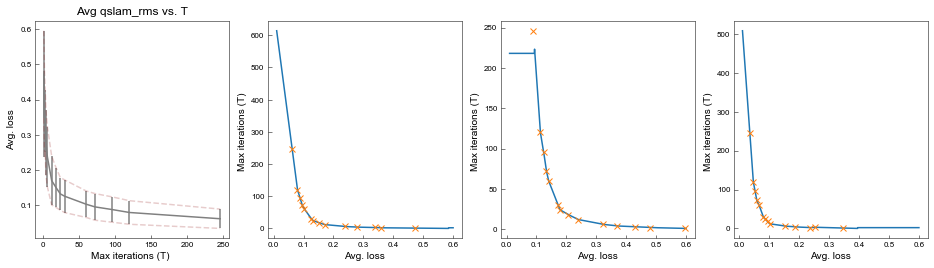

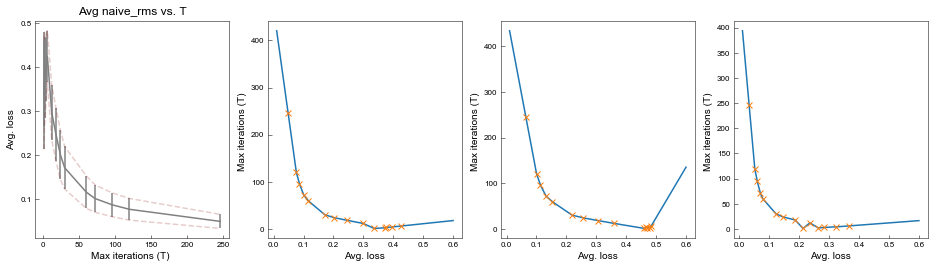

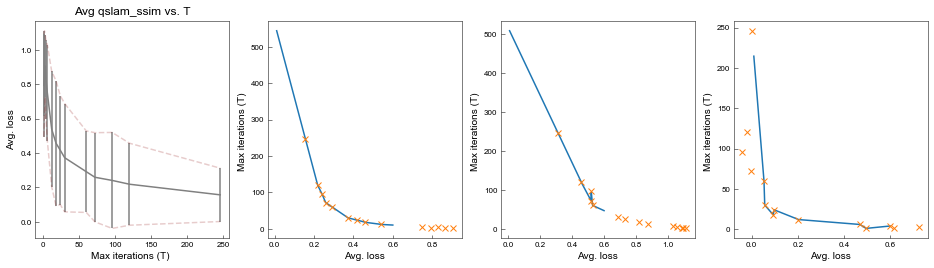

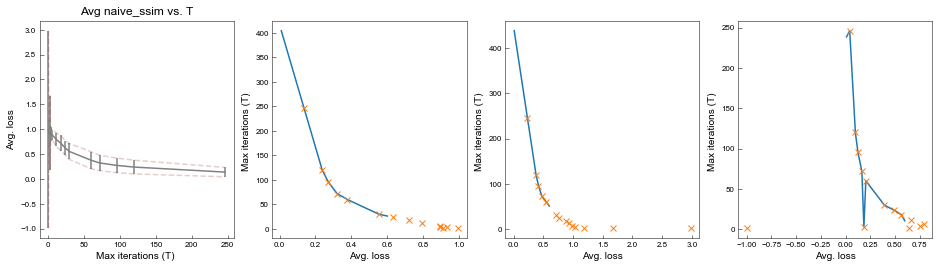

In [16]:
if FIT_TYPE == 'rbffit' or FIT_TYPE == 'linfit' or  FIT_TYPE == 'unifit':

    curve_fit_data = np.empty((max_cases, 4, 3, len(x_space))) # alwasy 601 entries
    
    for idx_case in range(max_cases):

        for idx_dataset in range(4):

            dataset = data_labels[idx_dataset]

            fig, (ax, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,4))

            # Plot expected loss, upper and lower bounds for each case:

            ax.errorbar(msmts, vars()[dataset+'_exp_loss'][idx_case][0:max_msmt_var], 
                        yerr= vars()[dataset+'_std_loss'][idx_case][0:max_msmt_var], 
                        c='gray')
            ax.plot(msmts,  vars()[dataset+'_errbar_upp'][idx_case][0:max_msmt_var], 
                    msmts,  vars()[dataset+'_errbar_low'][idx_case][0:max_msmt_var], 
                    c='darkred', ls='--', alpha=0.2)
            ax.set(title='Avg '+ dataset +' vs. T', xlabel='Max iterations (T) ', ylabel='Avg. loss')


            # Plot loss data and optimise power law fit

            axes = [ax2, ax3, ax4]
            xvals = [vars()[dataset+'_exp_loss'][idx_case], vars()[dataset+'_errbar_upp'][idx_case], vars()[dataset+'_errbar_low'][idx_case]]
            y_vals = msmts
            
            START = LINFIT[str(idx_case)][data_labels[idx_dataset]]["str"]
            END = LINFIT[str(idx_case)][data_labels[idx_dataset]]["end"]
            
            x_space = np.linspace(START, END, 601)
            
            for idx_plot in range(3):

                x_vals = xvals[idx_plot][0:max_msmt_var]


                if FIT_TYPE == 'rbffit':
                    interpolate_func = Rbf(x_vals, y_vals)
                
                if FIT_TYPE == 'linfit':
                    interpolate_func = interp1d(x_vals, y_vals, fill_value='extrapolate')
                
                if FIT_TYPE == 'unifit':
                    # ValueError: x must be strictly increasing
                    # Known bug as of Aug 2019 that data needs to be strictly increasing
                    # Noisy data won't be strictly increasing
                    interpolate_func = InterpolatedUnivariateSpline(x_vals, y_vals)

                interpolated_values = interpolate_func(x_space)
                
                if OPT_LAMBDA:
                    if idx_plot == 1 and idx_case == 0 and idx_dataset == 0:
                        interpolated_values[0:85] = [interpolated_values[86]]*85
                
                interpolated_values[interpolated_values<0] = 2.
                
                curve_fit_data[idx_case, idx_dataset, idx_plot, : ] = interpolated_values

#                 axes[idx_plot].set_title(labels[idx_plot]+'\n' + FIT_TYPE)
                axes[idx_plot].plot(x_space, interpolated_values)
                axes[idx_plot].plot(x_vals, y_vals, 'x')
                axes[idx_plot].set(ylabel='Max iterations (T) ', xlabel='Avg. loss')
#                 axes[idx_plot].set_xscale('log')
#                 axes[idx_plot].set_yscale('log')
            
            plt.show()


# Save error analysis curve fitting data

In [17]:
figdatafile = './FIGURES/selected_expt' + metrictypename+'_'+ str(metrictype_)+'_'+'_opt_'+ str(OPT_LAMBDA)
figdatafile += '_' + FIT_TYPE
print(figdatafile)
np.savez(figdatafile, curve_fit_data=curve_fit_data, opt_lambda=OPT_LAMBDA, loss_metric=metrictypename)

./FIGURES/selected_exptSSIM_3__opt_True_linfit


# Compute ratio and plot final data figure

### Take the ratio of expected naive / nmqa expected loss and computed expected supremum and infimum bounds for the ratio



RMS/$\pi$: 1D array
('Ratio drops below unity for score:', 0.08965)
('Max ratio', 26385.62558485292, 'for score ', 0.5842666666666666)
[[189]
 [190]
 [191]
 [192]
 [193]
 [194]
 [195]
 [196]
 [197]
 [198]]
('Ratio at Avg. SSIM = 0.2: ', 2.6321161369145543)
AxesHostAxes(0.125,0.125;0.227941x0.755)


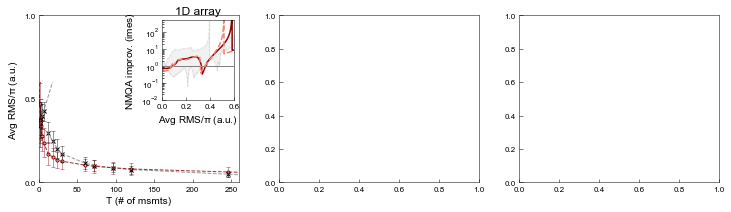



SSIM: 1D array
('Ratio drops below unity for score:', 0.187)
('Max ratio', 2.6846289418142035, 'for score ', 0.5390333333333333)
[[189]
 [190]
 [191]
 [192]
 [193]
 [194]
 [195]
 [196]
 [197]
 [198]]
('Ratio at Avg. SSIM = 0.2: ', 1.091540827554045)
AxesHostAxes(0.125,0.125;0.227941x0.755)


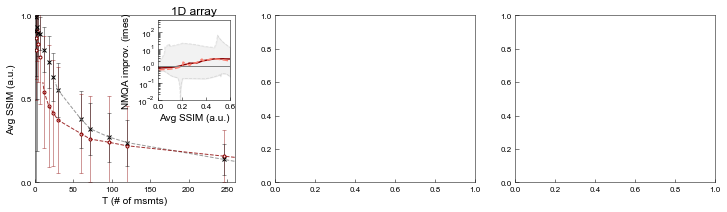

In [18]:
loss_label = ['RMS/$\pi$', 'SSIM']
case_titles = ['1D array', '2D square field', '2D Gaussian field']
XLIMMAX = 260

if FIT_TYPE == 'linfit':

    for plot_metric in [0, 1]: # 0 RMS, 1# SSIM

        fig, axes_ = plt.subplots(1, 3, figsize=(cm2inch(30.95), cm2inch(7.8)))
        axes = np.empty_like(axes_)
        axes = np.vstack([axes, axes])


        for idx_case in range(max_cases):
            
            idx_dataset_nmqa = plot_metric*2
            idx_dataset_naive = plot_metric*2 + 1
            
            START = LINFIT[str(idx_case)][data_labels[idx_dataset_nmqa]]["str"]
            END = LINFIT[str(idx_case)][data_labels[idx_dataset_nmqa]]["end"] # doesn't matter if naive or nmqa
            x_space = np.linspace(START, END, 601)

            axes[0, idx_case] = axes_[idx_case]
            axes[1, idx_case] = inset_axes(axes[0, idx_case], width=1, height=1.1)#, loc=4)


            naive_vals, nmqa_vals = [], []
            for idx_label in range(3):

                naive_vals.append(curve_fit_data[idx_case, idx_dataset_naive, idx_label, : ]) 
                nmqa_vals.append(curve_fit_data[idx_case, idx_dataset_nmqa, idx_label, : ] )

            naive_vals = np.asarray(naive_vals)
            nmqa_vals = np.asarray(nmqa_vals)
            naive_mask = naive_vals<=XLIMMAX
            nmqa_mask = nmqa_vals<=XLIMMAX


            # compute ratio
            mean = naive_vals[0] / nmqa_vals[0]
            high = naive_vals[1] / nmqa_vals[2]
            low  = naive_vals[2] / nmqa_vals[1]

            print 
            print
            print(loss_label[plot_metric] + ': ' +case_titles[idx_case])
            below_unity_arg = len(mean[0:200][mean[0:200]<1.0]) - 1
            print("Ratio drops below unity for score:", x_space[0:200][below_unity_arg])
            print("Max ratio", np.max(mean), "for score ", x_space[np.argmax(mean)])

            condition_match = np.argwhere(np.round(x_space, 2)==0.2)
            print condition_match
            at_point_1 = int(condition_match[-1])
            print("Ratio at Avg. SSIM = 0.2: ", mean[at_point_1] )


            axes[1, idx_case].set_title(case_titles[idx_case])

            axes[0, idx_case].plot( msmts, vars()[data_labels[idx_dataset_nmqa] +'_exp_loss'][idx_case],
                                   'o', ms=3, markerfacecolor='white', markeredgecolor='darkred', label='NMQA')
            axes[0, idx_case].plot( msmts, vars()[data_labels[idx_dataset_naive] +'_exp_loss'][idx_case],
                                   'x', ms=3.5, c='k', label='Naive')

            axes[0, idx_case].errorbar(msmts, vars()[data_labels[idx_dataset_nmqa] +'_exp_loss'][idx_case],
                         yerr=vars()[data_labels[idx_dataset_nmqa] +'_std_loss'][idx_case],
                         alpha=0.5 , color='darkred', ls='none',capsize=2, elinewidth=0.8, markeredgewidth=0.8)

            axes[0, idx_case].errorbar(msmts, vars()[data_labels[idx_dataset_naive] +'_exp_loss'][idx_case],
                         yerr=vars()[data_labels[idx_dataset_naive] +'_std_loss'][idx_case], 
                         alpha=0.5, color='k', ls='none', capsize=2, elinewidth=0.8, markeredgewidth=0.8)

            axes[0, idx_case].plot(naive_vals[0][naive_mask[0]], x_space[naive_mask[0]], '--', lw=1.0,
                                   alpha=0.8, c='gray', label='Naive Fit')
            axes[0, idx_case].plot(nmqa_vals[0][nmqa_mask[0]], x_space[nmqa_mask[0]], '--', lw=1.0,
                                   alpha=0.8, c='darkred', label='NMQA Fit')

            axes[0, idx_case].yaxis.set_ticks(np.arange(0., 1.1, 0.5))
            axes[0, idx_case].set_ylim([0., 1.])
            axes[0, idx_case].set_xlim([0, 260])
       

            MAINCOLOR='darkred'
            MAINLABEL='Numerically Tuned'
            if not OPT_LAMBDA:
                MAINCOLOR='salmon'
                MAINLABEL='Fixed Choice'
            axes[1, idx_case].plot(x_space, mean, '-', c=MAINCOLOR, lw=1.5,
                                  label=r'$\lambda_{1,2}$ ' + MAINLABEL)
            axes[1, idx_case].plot(x_space, high, '--', c='gray', lw=0.8, alpha=0.2)
            axes[1, idx_case].plot(x_space, low, '--', c='gray', lw=0.8, alpha=0.2)
            axes[1, idx_case].fill_between(x_space, y1=high, y2=low, color='gray', alpha=0.1, label='Est. Uncert.')
            axes[1, idx_case].axhline(y=1.0, lw=1.0, c='gray', ls='-')
            axes[1, idx_case].set_yscale('log') 
#             axes[1, idx_case].set_ylim([0, 10])
            axes[1, idx_case].set_ylim([10**-2, 5 * 10.**2])
#             if plot_metric == 1:
#                 axes[1, idx_case].set_ylim([0.5 * 10**-1, 5 * 10.**5])
 
            if FIT_TYPE == 'linfit':
            
                axes[1, idx_case].set_xlim([0., END])        
        

            axes[0, idx_case].set_xlabel('T (# of msmts)')
            axes[1, idx_case].set_xlabel(r'Avg '+loss_label[plot_metric]+' (a.u.)')
            axes[0, idx_case].set_ylabel(r'Avg '+loss_label[plot_metric]+' (a.u.)')
            axes[1, idx_case].set_ylabel('NMQA improv. ($\times$)')
            
            print(axes[1, idx_case])

        if OPT_LAMBDA:

            fixed_curve_fit_data = np.load('./FIGURES/selected_exptSSIM_3__opt_False_'+FIT_TYPE+'.npz')['curve_fit_data']
            
            for idx_case in range(max_cases):

                fnaive_vals = fixed_curve_fit_data[idx_case, idx_dataset_naive, 0, : ] 
                fnmqa_vals = fixed_curve_fit_data[idx_case, idx_dataset_nmqa, 0, : ] 

                fixed_mean = np.asarray(fnaive_vals) / np.asarray(fnmqa_vals)

                axes[1, idx_case].plot(x_space, fixed_mean, '--', c='salmon', lw=1.5,
                                       label=r'$\lambda_{1,2}$ Fixed Choice')
    #     axes[0, 0].legend()
    #     axes[1, 0].legend(loc=3)

        figdatafile =  metrictypename+'_'+ str(metrictype_)+'_opt_'+ str(OPT_LAMBDA)+'_'+str(plot_metric)
        figdatafile += '_' + FIT_TYPE
        plt.savefig('./FIGURES/selected_expt' +figdatafile+'.svg', format='svg', dpi=900)
        plt.show()

In [19]:
loss_label = ['RMS/$\pi$', 'SSIM']
case_titles = ['Expt']
XLIMMAX = 180

if FIT_TYPE == 'expfit' or FIT_TYPE == 'mixfit':
    for plot_metric in [0, 1]: # 0 RMS, 1# SSIM

        # fig, axes = plt.subplots(2, 3, figsize=(cm2inch(26), cm2inch(14)))
        # fig.suptitle(loss_label[plot_metric])

        fig, axes_ = plt.subplots(1, 3, figsize=(cm2inch(30.95), cm2inch(7.8)))
        axes = np.empty_like(axes_)
        axes = np.vstack([axes, axes])


        for idx_case in range(max_cases):

            idx_dataset_nmqa = plot_metric*2
            idx_dataset_naive = plot_metric*2 + 1

            axes[1, idx_case] = axes_[idx_case]

            if plot_metric == 0:
                axes[0, idx_case] = inset_axes(axes[1, idx_case], width=2., height=0.8)
            if plot_metric == 1:
                axes[0, idx_case] = inset_axes(axes[1, idx_case], width=2., height=0.8) #, loc=4)

            naive_vals, nmqa_vals = [], []
            for idx_label in range(3):

                opt_naive = curve_fit_data[idx_case, idx_dataset_naive, idx_label, : ] 
                opt_nmqa = curve_fit_data[idx_case, idx_dataset_nmqa, idx_label, : ] 

                # extract fitting function
                if FIT_TYPE == 'expfit':
                    naive_vals.append(fit_expn(x_space, opt_naive[0], opt_naive[1],  opt_naive[2]))
                
                if FIT_TYPE == 'mixfit':
                    naive_vals.append(fit_sqrt(x_space, opt_naive[0], opt_naive[1],  opt_naive[2]))
                nmqa_vals.append(fit_expn(x_space, opt_nmqa[0], opt_nmqa[1],  opt_nmqa[2]))

            naive_vals = np.asarray(naive_vals)
            nmqa_vals = np.asarray(nmqa_vals)
            naive_mask = naive_vals<=XLIMMAX
            nmqa_mask = nmqa_vals<=XLIMMAX


            # compute ratio
            mean = naive_vals[0] / nmqa_vals[0]
            high = naive_vals[1] / nmqa_vals[2]
            low  = naive_vals[2] / nmqa_vals[1]

            print 
            print
            print(loss_label[plot_metric] + ': ' +case_titles[idx_case])
            below_unity_arg = len(mean[mean<1.0]) - 1
            print("Ratio drops below unity for score:", x_space[below_unity_arg])
            print("Max ratio", np.max(mean), "for score ", x_space[np.argmax(mean)])

            condition_match = np.argwhere(np.round(x_space, 3)==0.100)
            at_point_1 = int(condition_match[-1])
            print("Ratio at Avg. SSIM = 0.1: ", mean[at_point_1] )


            axes[1, idx_case].set_title(case_titles[idx_case])

            axes[0, idx_case].plot( msmts, vars()[data_labels[idx_dataset_nmqa] +'_exp_loss'][idx_case],
                                   'o', ms=3, markerfacecolor='white', markeredgecolor='darkred', label='NMQA')
            axes[0, idx_case].plot( msmts, vars()[data_labels[idx_dataset_naive] +'_exp_loss'][idx_case],
                                   'x', ms=3.5, c='k', label='Naive')

            axes[0, idx_case].errorbar(msmts, vars()[data_labels[idx_dataset_nmqa] +'_exp_loss'][idx_case],
                         yerr=vars()[data_labels[idx_dataset_nmqa] +'_std_loss'][idx_case],
                         alpha=0.5 , color='darkred', ls='none',capsize=2, elinewidth=0.8, markeredgewidth=0.8)

            axes[0, idx_case].errorbar(msmts, vars()[data_labels[idx_dataset_naive] +'_exp_loss'][idx_case],
                         yerr=vars()[data_labels[idx_dataset_naive] +'_std_loss'][idx_case], 
                         alpha=0.5, color='k', ls='none', capsize=2, elinewidth=0.8, markeredgewidth=0.8)

            axes[0, idx_case].plot(naive_vals[0][naive_mask[0]], x_space[naive_mask[0]], '--', lw=1.0,
                                   alpha=0.8, c='gray', label='Naive Fit')
            axes[0, idx_case].plot(nmqa_vals[0][nmqa_mask[0]], x_space[nmqa_mask[0]], '--', lw=1.0,
                                   alpha=0.8, c='darkred', label='NMQA Fit')

            axes[0, idx_case].yaxis.set_ticks(np.arange(0., 1.1, 0.5))
    #         axes[0, idx_case].set_ylim([0., 1.])
    #         axes[0, idx_case].set_xlim([0, 250])
            axes[0, idx_case].set_yscale('log')
            axes[0, idx_case].set_xscale('log')
            axes[0, idx_case].set_ylim([10**-2, 2* 10**0])
            axes[0, idx_case].set_xlim([10**0, 3*10**2])

            MAINCOLOR='darkred'
            MAINLABEL='Numerically Tuned'
            if not OPT_LAMBDA:
                MAINCOLOR='salmon'
                MAINLABEL='Fixed Choice'
            axes[1, idx_case].plot(x_space, mean, '-', c=MAINCOLOR, lw=1.5,
                                  label=r'$\lambda_{1,2}$ ' + MAINLABEL)
            axes[1, idx_case].plot(x_space, high, '--', c='gray', lw=0.8, alpha=0.2)
            axes[1, idx_case].plot(x_space, low, '--', c='gray', lw=0.8, alpha=0.2)
            axes[1, idx_case].fill_between(x_space, y1=high, y2=low, color='gray', alpha=0.1, label='Est. Uncert.')
            axes[1, idx_case].axhline(y=1.0, lw=1.0, c='gray', ls='-')
            axes[1, idx_case].set_yscale('log') 
            axes[1, idx_case].set_ylim([10**-1, 10.**4])
            
            if FIT_TYPE != 'mixfit':
                axes[1, idx_case].set_xlim([0., 1.])  
            if FIT_TYPE == 'mixfit':
                axes[1, idx_case].set_xlim([0., 0.5])        


            axes[0, idx_case].set_xlabel('T (# of msmts)')
            axes[1, idx_case].set_xlabel(r'Avg '+loss_label[plot_metric]+' (a.u.)')
            axes[0, idx_case].set_ylabel(r'Avg '+loss_label[plot_metric]+' (a.u.)')
            axes[1, idx_case].set_ylabel('NMQA improvement (multiples)')


        if OPT_LAMBDA:
            fixed_curve_fit_data = np.load('./FIGURES/selected_exptSSIM_3__opt_False_'+FIT_TYPE+'.npz')['curve_fit_data']

            for idx_case in range(max_cases):

                fixed_naive = fixed_curve_fit_data[idx_case, idx_dataset_naive, 0, : ] 
                fixed_nmqa = fixed_curve_fit_data[idx_case, idx_dataset_nmqa, 0, : ] 

                # extract fitting function
                if FIT_TYPE == 'expfit':
                    fnaive_vals = fit_expn(x_space, fixed_naive[0], fixed_naive[1],  fixed_naive[2])
                
                if FIT_TYPE == 'mixfit':
                    fnaive_vals = fit_sqrt(x_space, fixed_naive[0], fixed_naive[1],  fixed_naive[2])

                fnmqa_vals = fit_expn(x_space, fixed_nmqa[0], fixed_nmqa[1],  fixed_nmqa[2])

                fixed_mean = np.asarray(fnaive_vals) / np.asarray(fnmqa_vals)

                axes[1, idx_case].plot(x_space, fixed_mean, '--', c='salmon', lw=1.5,
                                       label=r'$\lambda_{1,2}$ Fixed Choice')
    #     axes[0, 0].legend()
    #     axes[1, 0].legend(loc=3)


        figdatafile =  metrictypename+'_'+ str(metrictype_)+'_opt_'+ str(OPT_LAMBDA)+'_'+str(plot_metric)
        figdatafile += '_' + FIT_TYPE
        plt.savefig('./FIGURES/selected_expt' +figdatafile+'.svg', format='svg', dpi=900)
        plt.show()

Pick Msmt regimes 7
with total msmts 24
('truth:', 0, 'idx_opt', 0)
(0.9497249182982189, 0.9445977633378564)
Pick Msmt regimes 11
with total msmts 96
('truth:', 0, 'idx_opt', 1)
(0.971231028691702, 0.9977036308513471)


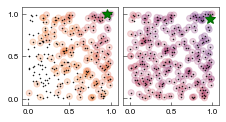

In [20]:
THRESHOLD=0.05

# Choose colormap
cmap = plt.cm.inferno
# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))
# Set alpha
my_cmap[:,-1] = np.ones(cmap.N)*0.2
# Create new colormap
my_cmap = ListedColormap(my_cmap)

# optimal_matrix, naive_matrix, optimal_cases = extract_optimal_cases(data_key_list, 
#                                                                     max_cases, 
#                                                                     max_msmt_var,
#                                                                     max_lambda_var=max_lambda_var_, 
#                                                                     metrictype=3)


gslayout = gs(3, 2 , top = 0.95, bottom =0.05, left = 0.1, right = 0.9, wspace = 0.05, hspace = 0.05)

fig = plt.figure(figsize=(cm2inch(8.7),cm2inch(12)))

for truth in range(len(data_key_list)):
       
    for idx_opt in range(len(pick_msmt_regimes)):
    
        data_key = data_key_list[truth]
        a, index_array, naive = get_loss_data(data_key,  pick_msmt_regimes[idx_opt], 
                                 max_lambda_var=max_lambda_var_, metrictype=metrictype_)

        
        print "Pick Msmt regimes", pick_msmt_regimes[idx_opt]
        print "with total msmts", meta_max_iter_scan[pick_msmt_regimes[idx_opt]]
        ax = fig.add_subplot(gslayout[truth, idx_opt ])
        ax.plot(lambda1[0:max_lambda_var_], lambda2[0:max_lambda_var_], 'ko', ms=0.5, alpha=1)
              
        optimal_color = 'green'
        diff = a[0] - a[index_array[0]]  
        if diff < 0 :
            optimal_color = 'g'
        elif diff >=0 :
            if diff < THRESHOLD: 
                optimal_color = 'g'



        better_than_control=[]
        for idx_l in index_array:
            diff = a[0] - a[idx_l] 

            if diff < 0 :
                break
            elif diff >=0 :
                if diff < THRESHOLD: 
                    break
            if idx_l == 0:
                break
            better_than_control.append(idx_l)
        
        red_values = np.take(a, better_than_control)
        im = ax.scatter(np.take(lambda1, better_than_control), 
                   np.take(lambda2, better_than_control),
                   c= red_values,
                   vmin=0.0, vmax=1.0, 
                   cmap= my_cmap)
        
        print("truth:", truth, "idx_opt", idx_opt)
        print(lambda1[index_array[0]], lambda2[index_array[1]]) 
        
        ax.plot(lambda1[index_array[0]],lambda2[index_array[0]], '*', markeredgecolor='darkgreen',
                c=optimal_color, ms=10, alpha=1.)
        
        if idx_opt >0:
            ax.get_yaxis().set_ticklabels([])
#         if truth < 2:
#             ax.get_xaxis().set_ticklabels([])
        
        # Want square graphs with same number of ticks
        # ax.set_aspect(1.)
        equaltics = plticker.MultipleLocator(base=0.5) # this locator puts ticks at regular intervals
        ax.xaxis.set_major_locator(equaltics)
        ax.yaxis.set_major_locator(equaltics)
        # ax.set(xlabel=r'$\lambda_i $', ylabel=r'$\lambda_j$')
        # ax.set_title(str(ParamUpdater.meta_max_iter_scan[pick_msmt_regimes[idx_opt]])+', '+str(np.round(a[index_array[0]] / a[0], 3)))
        
# plt.colorbar(im, ticks=[0.0, 0.7], format='%0.2f', orientation='horizontal')
plt.savefig('./FIGURES/selected_expt_optimisation' +figdatafile+'.svg', format='svg', dpi=900)
plt.show()

In [21]:
for idx_msmt_regime in range(len(msmts)):
    
    print("Msmts", msmts[idx_msmt_regime])
    opt_lambda =  int(optimal_cases[0, idx_msmt_regime, 0])
    print("Index for optimal lambda: ", opt_lambda)
    print("Optimal pair: ", lambda1[opt_lambda], lambda2[opt_lambda] )
    print
    print

('Msmts', 1)
('Index for optimal lambda: ', 134)
('Optimal pair: ', 0.6392149022358897, 0.14273015242855036)


('Msmts', 2)
('Index for optimal lambda: ', 151)
('Optimal pair: ', 0.1758026752442703, 0.9076306148585008)


('Msmts', 3)
('Index for optimal lambda: ', 172)
('Optimal pair: ', 0.4993102688765002, 0.027416983744806944)


('Msmts', 4)
('Index for optimal lambda: ', 47)
('Optimal pair: ', 0.483588236157135, 0.9628845967774097)


('Msmts', 6)
('Index for optimal lambda: ', 107)
('Optimal pair: ', 0.971231028691702, 0.9445977633378564)


('Msmts', 12)
('Index for optimal lambda: ', 29)
('Optimal pair: ', 0.981019523280572, 0.9912799630798892)


('Msmts', 18)
('Index for optimal lambda: ', 249)
('Optimal pair: ', 1.0, 1.0)


('Msmts', 24)
('Index for optimal lambda: ', 30)
('Optimal pair: ', 0.9497249182982189, 0.9977036308513471)


('Msmts', 30)
('Index for optimal lambda: ', 30)
('Optimal pair: ', 0.9497249182982189, 0.9977036308513471)


('Msmts', 60)
('Index for optimal lambda